In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gc
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from data import MemmapDataset
from models import *
from torchvision.models import ResNet50_Weights
from torchgeo.models import resnet50, get_weight
from typing import List
import os

d:\conda\envs\mangrove-monitoring\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

Dataset containing 6357 images loaded.
Using CUDA device.
torch.Size([3, 256, 256])


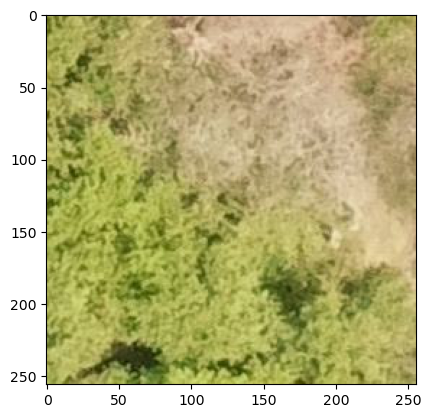

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


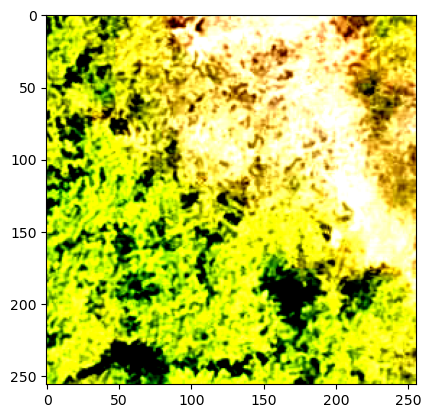

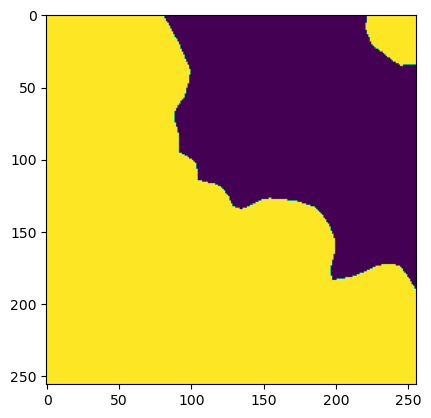

In [15]:
# Config
DATA_SPLIT = 0.90
INIT_LR = 0.005
NUM_EPOCHS = 20
BATCH_SIZE = 256
INPUT_IMAGE_SIZE = 256
THRESHOLD = 0.5
LOSS = JaccardLoss()

# define the path to each directory
BASE_DIR = "d:/Data/Validation"
IMAGE_DIR = BASE_DIR + "/original.npy"
LABEL_DIR = BASE_DIR + "/labels.npy"

imgs = np.load(IMAGE_DIR, mmap_mode='r')

dataset = MemmapDataset(np.load(IMAGE_DIR, 'r'), np.load(LABEL_DIR, 'r'))
print(f"Dataset containing {len(dataset)} images loaded.")

# Setup the device to be used for training and evaluation
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using CUDA device.")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using Apple Metal Performance Shaders (MPS) device.\n")
else:
    DEVICE = torch.device("cpu")
    print("WARNING: No GPU found. Defaulting to CPU.")

print(dataset[0][0].shape)
i=6
plt.imshow(imgs[i].T)
plt.show()
plt.imshow(dataset[i][0].T)
plt.show()
plt.imshow(dataset[i][1].T)
plt.show()

# Training Pipeline

In [5]:
# Training Functions
def train(model, dataset: MemmapDataset, model_name, BATCH_SIZE, save_model_every_x_epochs = 5):
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    elif torch.backends.mps.is_available():
        torch.mps.empty_cache()

    opt = Adam(model.parameters(), lr=INIT_LR)
    print("[INFO] training the network...")
    training_loss = []
    all_metrics = []

    train_ds, valid_ds = dataset.split(DATA_SPLIT)
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)

    for epoch in tqdm(range(NUM_EPOCHS)):
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}:")
        model.train()
        total_train_loss = 0
        
        for batch_idx, (x, y) in enumerate(train_loader):
            print(f" Batch {batch_idx + 1}/{len(train_loader)}", end="\r")
            
            # Send the input to the device
            x = x.to(DEVICE)
            y = y.float().to(DEVICE)

            # Perform a forward pass and calculate the training loss
            pred = model(x)
            if isinstance(pred, tuple):
                pred = pred[0]
            loss = LOSS(pred, y)

            # Zero out any previously accumulated gradients, perform backpropagation, and update model parameters
            opt.zero_grad()
            loss.backward()
            opt.step()

            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        training_loss.append(avg_train_loss)

        # Evaluate on validation dataset
        metrics = evaluate(model, test_loader)
        all_metrics.append(metrics)
        avg_test_loss = metrics['Loss']

        # Print Epoch Metrics
        print(f"Epoch: {epoch + 1}/{NUM_EPOCHS}")
        print(f"Train loss: {avg_train_loss:.6f}, Test loss: {avg_test_loss:.4f}")
        print("\nValidation Metrics:")
        for k, v in metrics.items():
            if k != 'Loss':
                print(f"{k}: {v}")
        print("\n")
        if int(epoch + 1)%save_model_every_x_epochs==0 or epoch == NUM_EPOCHS-1:
            # Save model in current directory
            try:
                if not os.path.exists("trained_models/"+model_name):
                    os.makedirs("trained_models/"+model_name)
                model_filename = f"trained_models/{model_name}/epoch_{epoch}.pth"
                torch.save(model.state_dict(), model_filename)
                print(f"Saved model to {model_filename}")
            except Exception as exc:
                print(f"Error saving model: {str(exc)}")

    return training_loss, all_metrics

def evaluate(model: nn.Module, dataloader: DataLoader):
    model.eval()
    total_loss = 0
    total_TP = 0
    total_FP = 0
    total_FN = 0
    total_TN = 0
    total_landmass_captured = 0
    total_landmass_actual = 0

    with torch.no_grad():
        for idx, (x, y) in enumerate(dataloader):
            x = x.to(DEVICE)
            y = y.to(DEVICE).float()
            
            pred = model(x)
            if isinstance(pred, tuple):
                pred = pred[0]
            loss = LOSS(pred, y)
            total_loss += loss.item()

            pred = torch.sigmoid(pred).view(-1)
            y = y.view(-1)
            
            TP = (pred * y).sum().item()
            FP = ((1 - y) * pred).sum().item()
            FN = (y * (1 - pred)).sum().item()
            TN = ((1 - y) * (1 - pred)).sum().item()

            total_TP += TP
            total_FP += FP
            total_FN += FN
            total_TN += TN
            
            total_landmass_actual += y.sum().item()
            total_landmass_captured += pred.sum().item()

            del x, y, pred, loss
            
            print(f"Batch {idx} / {len(dataloader)}", end="\r")

    total_landmass_captured = total_landmass_captured / total_landmass_actual if total_landmass_actual > 0 else 0
    avg_loss = total_loss / len(dataloader)
    precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
    recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    iou = total_TP / (total_TP + total_FP + total_FN) if (total_TP + total_FP + total_FN) > 0 else 0
    accuracy = (total_TP + total_TN) / (total_TP + total_FP + total_FN + total_TN) if (total_TP + total_FP + total_FN + total_TN) > 0 else 0
    specificity = total_TN / (total_TN + total_FP) if (total_TN + total_FP) > 0 else 0

    metrics = {
        'Landmass Captured': total_landmass_captured,
        'Loss': avg_loss,
        'Precision': precision,
        'Recall': recall,
        'f1_score': f1_score,
        'IOU': iou,
        'Accuracy': accuracy,
        'Specificity': specificity
    }

    return metrics


In [ ]:
model = ResNet_UNet(input_image_size=INPUT_IMAGE_SIZE).to(DEVICE)
model.load_state_dict(torch.load("ResNet18_UNet-pth"))
BATCH_SIZE = 64
test_set = MemmapDataset(np.load("d:/Data/Validation/original.npy", 'r'), np.load("d:/Data/Validation/labels.npy", 'r'))
test_dataloader = DataLoader(test_set, BATCH_SIZE, shuffle=True)
metrics = evaluate(model, test_dataloader)
for k, v in metrics.items():
    if k != 'Loss':
        print(f"{k}: {v}")

Landmass Captured: 0.986616272475992
Precision: 0.9423425434103762
Recall: 0.9297304907442663
f1_score: 0.9359940337260976
IOU: 0.8796887079533054
Accuracy: 0.959138485084801
Specificity: 0.9730636510380689


In [20]:
BATCH_SIZE = 64
NUM_EPOCHS = 50

test_set = MemmapDataset(np.load("d:/Data/Validation/images.npy", 'r'), np.load("d:/Data/Validation/labels.npy", 'r'))

model = ResNet_UNet(input_image_size=INPUT_IMAGE_SIZE).to(DEVICE)
training_loss, metrics = train(model, dataset, model_name="ResNet_Unet_control", BATCH_SIZE=BATCH_SIZE, save_model_every_x_epochs=10)
valid_loss = [x['Loss'] for x in metrics]

[INFO] training the network...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:
Epoch: 1/50 3755
Train loss: 0.245788, Test loss: 0.2149

Validation Metrics:
Landmass Captured: 1.0979670047668506
Precision: 0.8409038298770288
Recall: 0.9232846636465387
f1_score: 0.8801708123335824
IOU: 0.7859866683487213
Accuracy: 0.9167400943780107
Specificity: 0.9134992984686969




  2%|▏         | 1/50 [2:20:18<114:34:58, 8418.33s/it]

Epoch 2/50:
Epoch: 2/50 3755
Train loss: 0.218717, Test loss: 0.1944

Validation Metrics:
Landmass Captured: 0.9910405683074449
Precision: 0.8971338842059287
Recall: 0.8890960752406758
f1_score: 0.8930968951612837
IOU: 0.8068428855761628
Accuracy: 0.9295071491737095
Specificity: 0.9495182512958217




  4%|▍         | 2/50 [4:35:59<110:04:06, 8255.14s/it]

Epoch 3/50:
Epoch: 3/50 3755
Train loss: 0.204725, Test loss: 0.1844

Validation Metrics:
Landmass Captured: 1.001446134807892
Precision: 0.8984946783839401
Recall: 0.8997940273967575
f1_score: 0.8991438834696569
IOU: 0.8167678500107363
Accuracy: 0.9331470164630352
Specificity: 0.9496630355088234




  6%|▌         | 3/50 [6:51:51<107:09:48, 8208.27s/it]

Epoch 4/50:
Epoch: 4/50 3755
Train loss: 0.196037, Test loss: 0.1862

Validation Metrics:
Landmass Captured: 1.0848839509698789
Precision: 0.8628502151687114
Recall: 0.9360923540920312
f1_score: 0.897980294588297
IOU: 0.8148495804372399
Accuracy: 0.9295565531339517
Specificity: 0.9263200991731807




  8%|▊         | 4/50 [9:06:44<104:18:00, 8162.63s/it]

Epoch 5/50:
Epoch: 5/50 3755
Train loss: 0.189561, Test loss: 0.1712

Validation Metrics:
Landmass Captured: 1.02854201245248
Precision: 0.8944753997462386
Recall: 0.9200055293025295
f1_score: 0.9070608573693221
IOU: 0.8299280554505979
Accuracy: 0.9375608026116935
Specificity: 0.94625397329147




 10%|█         | 5/50 [11:22:37<101:59:18, 8159.08s/it]

Epoch 6/50:
Epoch: 6/50 3755
Train loss: 0.183701, Test loss: 0.1745

Validation Metrics:
Landmass Captured: 1.0314050388631901
Precision: 0.8911738059317034
Recall: 0.9191611556128917
f1_score: 0.9049511418740228
IOU: 0.826402525475183
Accuracy: 0.9360533091238837
Specificity: 0.9444181105394777




 12%|█▏        | 6/50 [13:41:44<100:30:13, 8223.03s/it]

Epoch 7/50:
Epoch: 7/50 3755
Train loss: 0.178830, Test loss: 0.1661

Validation Metrics:
Landmass Captured: 1.0070874859865955
Precision: 0.9068048907215965
Recall: 0.9132318595896867
f1_score: 0.9100070276021308
IOU: 0.8348742153816017
Accuracy: 0.9401795679112152
Specificity: 0.9535237651654517




 14%|█▍        | 7/50 [16:00:23<98:35:47, 8254.60s/it] 

Epoch 8/50:
Epoch: 8/50 3755
Train loss: 0.174213, Test loss: 0.1696

Validation Metrics:
Landmass Captured: 1.0503755482822295
Precision: 0.8861972447980487
Recall: 0.9308399175714014
f1_score: 0.9079701696624891
IOU: 0.8314518014419671
Accuracy: 0.93750623624461
Specificity: 0.940807321083476




 16%|█▌        | 8/50 [18:17:20<96:09:48, 8242.58s/it]

Epoch 9/50:
Epoch: 9/50 3755
Train loss: 0.170749, Test loss: 0.1681

Validation Metrics:
Landmass Captured: 0.9891520396017731
Precision: 0.9139527927874658
Recall: 0.9040382675191702
f1_score: 0.908968495418813
IOU: 0.8331276334387224
Accuracy: 0.9400299590893056
Specificity: 0.9578526334868778




 18%|█▊        | 9/50 [20:36:33<94:16:02, 8277.14s/it]

Epoch 10/50:
Epoch: 10/503755
Train loss: 0.167029, Test loss: 0.1638

Validation Metrics:
Landmass Captured: 1.0209924858414083
Precision: 0.9021354519408957
Recall: 0.9210735194190542
f1_score: 0.9115061287704157
IOU: 0.8374012503540883
Accuracy: 0.9407685261323315
Specificity: 0.9505212684389149


Saved model to trained_models/ResNet_Unet_control/epoch_9.pth


 20%|██        | 10/50 [22:53:27<91:44:59, 8257.49s/it]

Epoch 11/50:
Epoch: 11/503755
Train loss: 0.163962, Test loss: 0.1573

Validation Metrics:
Landmass Captured: 1.0397688241989682
Precision: 0.897799213224989
Recall: 0.9335036336984565
f1_score: 0.9153033637064812
IOU: 0.8438335043004599
Accuracy: 0.9427834381105519
Specificity: 0.9473786912127669




 22%|██▏       | 11/50 [25:15:02<90:14:37, 8330.20s/it]

Epoch 12/50:
Epoch: 12/503755
Train loss: 0.160143, Test loss: 0.1579

Validation Metrics:
Landmass Captured: 1.039238263113525
Precision: 0.8976692620836859
Recall: 0.9328922419986222
f1_score: 0.9149418783372875
IOU: 0.8432192341321368
Accuracy: 0.9425541836471584
Specificity: 0.9473386667735505




 24%|██▍       | 12/50 [27:37:46<88:40:48, 8401.29s/it]

Epoch 13/50:
Epoch: 13/503755
Train loss: 0.158266, Test loss: 0.1535

Validation Metrics:
Landmass Captured: 1.0227039678417318
Precision: 0.9073126291134577
Recall: 0.9279122253106025
f1_score: 0.917496816483878
IOU: 0.8475696242330852
Accuracy: 0.9447314999576715
Specificity: 0.9530602125718486




 26%|██▌       | 13/50 [29:55:16<85:52:38, 8355.63s/it]

Epoch 14/50:
Epoch: 14/503755
Train loss: 0.153980, Test loss: 0.1553

Validation Metrics:
Landmass Captured: 0.99614108486686
Precision: 0.9183155630159663
Recall: 0.9147718606361088
f1_score: 0.9165402865048021
IOU: 0.845938501532355
Accuracy: 0.9448249457959248
Specificity: 0.9597068901819673




 28%|██▊       | 14/50 [32:11:48<83:03:39, 8306.10s/it]

Epoch 15/50:
Epoch: 15/503755
Train loss: 0.152113, Test loss: 0.1520

Validation Metrics:
Landmass Captured: 1.0276938490024028
Precision: 0.9059870786307456
Recall: 0.9310773503916486
f1_score: 0.9183608754642125
IOU: 0.8490455408206041
Accuracy: 0.9451754129262387
Specificity: 0.95215661242208




 30%|███       | 15/50 [34:27:48<80:19:30, 8262.02s/it]

Epoch 16/50:
Epoch: 16/503755
Train loss: 0.149149, Test loss: 0.1536

Validation Metrics:
Landmass Captured: 0.9818731896403057
Precision: 0.9260484652624296
Recall: 0.9092621627068065
f1_score: 0.9175785477007
IOU: 0.8477091300727294
Accuracy: 0.9459008091175439
Specificity: 0.9640438480756985




 32%|███▏      | 16/50 [36:43:25<77:40:25, 8224.29s/it]

Epoch 17/50:
Epoch: 17/503755
Train loss: 0.147029, Test loss: 0.1486

Validation Metrics:
Landmass Captured: 1.0210868590709066
Precision: 0.9109102540634437
Recall: 0.9301184888463333
f1_score: 0.920414167619154
IOU: 0.8525622882520922
Accuracy: 0.9467284435058249
Specificity: 0.9549535032596359




 34%|███▍      | 17/50 [39:00:12<75:20:29, 8219.07s/it]

Epoch 18/50:
Epoch: 18/503755
Train loss: 0.144629, Test loss: 0.1518

Validation Metrics:
Landmass Captured: 1.0053508845445212
Precision: 0.9161592037739807
Recall: 0.921061466791945
f1_score: 0.9186037949192815
IOU: 0.8494609011973683
Accuracy: 0.9459408545683388
Specificity: 0.9582608430807492




 36%|███▌      | 18/50 [41:15:35<72:48:11, 8190.37s/it]

Epoch 19/50:
Epoch: 19/503755
Train loss: 0.142796, Test loss: 0.1517

Validation Metrics:
Landmass Captured: 0.9870046088685861
Precision: 0.9247533712485868
Recall: 0.9127358402749997
f1_score: 0.9187053072859722
IOU: 0.8496345293067521
Accuracy: 0.9465022258402926
Specificity: 0.9632229540978311




 38%|███▊      | 19/50 [43:34:18<70:52:15, 8230.16s/it]

Epoch 20/50:
Epoch: 20/503755
Train loss: 0.140264, Test loss: 0.1456

Validation Metrics:
Landmass Captured: 1.0023757534419144
Precision: 0.9210727525073249
Recall: 0.923260993746664
f1_score: 0.9221655749889184
IOU: 0.8555725755182086
Accuracy: 0.9483830967991788
Specificity: 0.9608232751999813


Saved model to trained_models/ResNet_Unet_control/epoch_19.pth


 40%|████      | 20/50 [45:53:05<68:49:35, 8259.18s/it]

Epoch 21/50:
Epoch: 21/503755
Train loss: 0.138568, Test loss: 0.1457

Validation Metrics:
Landmass Captured: 1.0140402580919798
Precision: 0.9157143388076044
Recall: 0.9285712047960676
f1_score: 0.922097957970372
IOU: 0.8554561750658844
Accuracy: 0.9480373087659023
Specificity: 0.9576767010626855




 42%|████▏     | 21/50 [48:11:15<66:36:30, 8268.64s/it]

Epoch 22/50:
Epoch: 22/503755
Train loss: 0.136863, Test loss: 0.1489

Validation Metrics:
Landmass Captured: 0.9803128285080809
Precision: 0.929545680035967
Recall: 0.9112455551730946
f1_score: 0.9203046527619155
IOU: 0.8523743805288237
Accuracy: 0.9477313341946533
Specificity: 0.965798675128474




 44%|████▍     | 22/50 [50:35:13<65:10:25, 8379.47s/it]

Epoch 23/50:
Epoch: 23/503755
Train loss: 0.135010, Test loss: 0.1444

Validation Metrics:
Landmass Captured: 1.0135402028966616
Precision: 0.9167461017744106
Recall: 0.9291590300324777
f1_score: 0.9229108300673806
IOU: 0.8568564756111289
Accuracy: 0.9485922824452113
Specificity: 0.9582154070559693




 46%|████▌     | 23/50 [52:57:34<63:12:34, 8427.96s/it]

Epoch 24/50:
Epoch: 24/503755
Train loss: 0.133646, Test loss: 0.1424

Validation Metrics:
Landmass Captured: 0.9995319309062733
Precision: 0.9242965440437972
Recall: 0.9238639082127219
f1_score: 0.9240801754904044
IOU: 0.8588745689406739
Accuracy: 0.9497242932730023
Specificity: 0.9625300604501367




 48%|████▊     | 24/50 [55:13:35<60:17:17, 8347.61s/it]

Epoch 25/50:
Epoch: 25/503755
Train loss: 0.131249, Test loss: 0.1427

Validation Metrics:
Landmass Captured: 0.9918726199250653
Precision: 0.9276668099061891
Recall: 0.9201273090252736
f1_score: 0.92388167786208
IOU: 0.8585316863917046
Accuracy: 0.9497859310218142
Specificity: 0.9644725417903997




 50%|█████     | 25/50 [57:30:15<57:39:42, 8303.29s/it]

Epoch 26/50:
Epoch: 26/503755
Train loss: 0.130140, Test loss: 0.1435

Validation Metrics:
Landmass Captured: 0.9754646160748462
Precision: 0.935136475370852
Recall: 0.912192543783045
f1_score: 0.9235220271086801
IOU: 0.857910751883
Accuracy: 0.9499642667112174
Specificity: 0.9686683923135812




 52%|█████▏    | 26/50 [59:47:53<55:15:53, 8289.73s/it]

Epoch 27/50:
Epoch: 27/503755
Train loss: 0.128659, Test loss: 0.1417

Validation Metrics:
Landmass Captured: 1.021501689624255
Precision: 0.9147107296395632
Recall: 0.9343785527470128
f1_score: 0.9244400428730579
IOU: 0.8594965224834525
Accuracy: 0.949412821679627
Specificity: 0.9568576198573967




 54%|█████▍    | 27/50 [62:09:43<53:23:08, 8356.00s/it]

Epoch 28/50:
Epoch: 28/503755
Train loss: 0.127449, Test loss: 0.1401

Validation Metrics:
Landmass Captured: 1.0249343652854959
Precision: 0.9140326530560007
Recall: 0.9368234778036122
f1_score: 0.9252877461245899
IOU: 0.8609632418240362
Accuracy: 0.94989541887802
Specificity: 0.9563684947587673




 56%|█████▌    | 28/50 [64:26:32<50:47:39, 8311.77s/it]

Epoch 29/50:
Epoch: 29/503755
Train loss: 0.125949, Test loss: 0.1410

Validation Metrics:
Landmass Captured: 1.0274280155250501
Precision: 0.9125128555429551
Recall: 0.9375412735385897
f1_score: 0.92485776633011
IOU: 0.860218989977913
Accuracy: 0.9495450023634394
Specificity: 0.9554891117259002




 58%|█████▊    | 29/50 [66:42:51<48:15:09, 8271.89s/it]

Epoch 30/50:
Epoch: 30/503755
Train loss: 0.125120, Test loss: 0.1395

Validation Metrics:
Landmass Captured: 0.9958331042966948
Precision: 0.9277404395319221
Recall: 0.923874639244923
f1_score: 0.9258035038812509
IOU: 0.8618567526763802
Accuracy: 0.9509564088826963
Specificity: 0.964366991754507


Saved model to trained_models/ResNet_Unet_control/epoch_29.pth


 60%|██████    | 30/50 [69:00:27<45:55:44, 8267.23s/it]

Epoch 31/50:


 62%|██████▏   | 31/50 [71:15:39<43:23:11, 8220.60s/it]

Epoch: 31/50375
Train loss: 0.124047, Test loss: 0.1403

Validation Metrics:
Landmass Captured: 1.0047262542626394
Precision: 0.9230092611672204
Recall: 0.9273716396336595
f1_score: 0.9251853081224699
IOU: 0.8607858778952105
Accuracy: 0.9503274316643573
Specificity: 0.9616948775908868


Epoch 32/50:
Epoch: 32/503755
Train loss: 0.123327, Test loss: 0.1404

Validation Metrics:
Landmass Captured: 0.9973691989354798
Precision: 0.9264149967273115
Recall: 0.9239777824170682
f1_score: 0.9251947845038873
IOU: 0.8608022841393008
Accuracy: 0.9505159914932184
Specificity: 0.9636574094312318




 64%|██████▍   | 32/50 [73:35:07<41:19:30, 8265.02s/it]

Epoch 33/50:
Epoch: 33/503755
Train loss: 0.121391, Test loss: 0.1364

Validation Metrics:
Landmass Captured: 1.0205320985616686
Precision: 0.9180541032513932
Recall: 0.9369036782694299
f1_score: 0.9273831186404474
IOU: 0.8645986603016913
Accuracy: 0.9514065208806187
Specificity: 0.9585881628656044




 66%|██████▌   | 33/50 [75:58:48<39:31:56, 8371.54s/it]

Epoch 34/50:
Epoch: 34/503755
Train loss: 0.120876, Test loss: 0.1359

Validation Metrics:
Landmass Captured: 0.9937608135224751
Precision: 0.9306639384513851
Recall: 0.9248573525646696
f1_score: 0.9277515600720846
IOU: 0.8652393657336122
Accuracy: 0.9522936517162711
Specificity: 0.9658797935319434




 68%|██████▊   | 34/50 [78:17:19<37:07:33, 8353.36s/it]

Epoch 35/50:
Epoch: 35/503755
Train loss: 0.119431, Test loss: 0.1359

Validation Metrics:
Landmass Captured: 1.016831685197073
Precision: 0.9200496923811603
Recall: 0.9355356788446139
f1_score: 0.9277280656335358
IOU: 0.8651984966683568
Accuracy: 0.9517259229355641
Specificity: 0.9597431468026241




 70%|███████   | 35/50 [80:32:53<34:31:55, 8287.70s/it]

Epoch 36/50:
Epoch: 36/503755
Train loss: 0.118880, Test loss: 0.1357

Validation Metrics:
Landmass Captured: 1.0037950674707286
Precision: 0.926026996569794
Recall: 0.9295413323673578
f1_score: 0.927780836497327
IOU: 0.8652902951916083
Accuracy: 0.9520729827087286
Specificity: 0.9632303984705923




 72%|███████▏  | 36/50 [82:50:36<32:12:02, 8280.17s/it]

Epoch 37/50:
Epoch: 37/503755
Train loss: 0.118050, Test loss: 0.1376

Validation Metrics:
Landmass Captured: 0.9918351222344207
Precision: 0.9306966121802701
Recall: 0.9230975902939265
f1_score: 0.926881526387001
IOU: 0.8637271179074534
Accuracy: 0.951765792299953
Specificity: 0.9659619583831138




 74%|███████▍  | 37/50 [85:09:14<29:56:32, 8291.73s/it]

Epoch 38/50:
Epoch: 38/503755
Train loss: 0.117217, Test loss: 0.1350

Validation Metrics:
Landmass Captured: 1.0203275013499067
Precision: 0.9189641066752229
Recall: 0.9376443504217811
f1_score: 0.9282102530241805
IOU: 0.8660376306483941
Accuracy: 0.9519648840937172
Specificity: 0.9590562487205462




 76%|███████▌  | 38/50 [87:28:00<27:40:21, 8301.83s/it]

Epoch 39/50:
Epoch: 39/503755
Train loss: 0.116281, Test loss: 0.1375

Validation Metrics:
Landmass Captured: 0.9937103770294824
Precision: 0.9298866394883928
Recall: 0.9240380046851137
f1_score: 0.9269530966500102
IOU: 0.8638514250925257
Accuracy: 0.9517676385313841
Specificity: 0.9654990363975275




 78%|███████▊  | 39/50 [89:44:31<25:15:56, 8268.78s/it]

Epoch 40/50:
Epoch: 40/503755
Train loss: 0.115702, Test loss: 0.1371

Validation Metrics:
Landmass Captured: 0.9731317981240218
Precision: 0.9398586489322176
Recall: 0.9146063353670691
f1_score: 0.9270605613378483
IOU: 0.8640381068420786
Accuracy: 0.9523357067471973
Specificity: 0.9710188603845515


Saved model to trained_models/ResNet_Unet_control/epoch_39.pth


 80%|████████  | 40/50 [92:02:59<23:00:03, 8280.31s/it]

Epoch 41/50:
Epoch: 41/503755
Train loss: 0.114897, Test loss: 0.1350

Validation Metrics:
Landmass Captured: 0.9917376732797909
Precision: 0.9321199841166449
Recall: 0.9244185031390734
f1_score: 0.9282532695961719
IOU: 0.8661125275804774
Accuracy: 0.9526730085820982
Specificity: 0.9666643168095858




 82%|████████▏ | 41/50 [94:20:25<20:40:32, 8270.24s/it]

Epoch 42/50:
Epoch: 42/503755
Train loss: 0.113865, Test loss: 0.1355

Validation Metrics:
Landmass Captured: 0.9889199185194856
Precision: 0.9332426015229711
Recall: 0.9229021978409823
f1_score: 0.9280435969861033
IOU: 0.865747519560338
Accuracy: 0.9526018504562622
Specificity: 0.9673087790060506




 84%|████████▍ | 42/50 [96:37:44<18:21:25, 8260.66s/it]

Epoch 43/50:
Epoch: 43/503755
Train loss: 0.113879, Test loss: 0.1347

Validation Metrics:
Landmass Captured: 1.0063638070370675
Precision: 0.925506954331894
Recall: 0.9313967021949503
f1_score: 0.9284424876792274
IOU: 0.8664420500103747
Accuracy: 0.9524511996417787
Specificity: 0.9628771461964033




 86%|████████▌ | 43/50 [98:55:52<16:04:42, 8268.91s/it]

Epoch 44/50:
Epoch: 44/503755
Train loss: 0.112735, Test loss: 0.1338

Validation Metrics:
Landmass Captured: 0.9927903523542264
Precision: 0.9323267183807992
Recall: 0.925604973178982
f1_score: 0.9289536865980532
IOU: 0.8673328827839694
Accuracy: 0.9531102620244407
Specificity: 0.9667305668093965




 88%|████████▊ | 44/50 [101:36:09<14:27:19, 8673.28s/it]

Epoch 45/50:
Epoch: 45/503755
Train loss: 0.112344, Test loss: 0.1349

Validation Metrics:
Landmass Captured: 0.9885651738493382
Precision: 0.9336794562579548
Recall: 0.9230029945962901
f1_score: 0.9283105290542558
IOU: 0.8662122323876529
Accuracy: 0.9527861027005513
Specificity: 0.967534357562153




 90%|█████████ | 45/50 [104:16:44<12:26:48, 8961.79s/it]

Epoch 46/50:
Epoch: 46/503755
Train loss: 0.111253, Test loss: 0.1332

Validation Metrics:
Landmass Captured: 1.0002240458490417
Precision: 0.9291579255249308
Recall: 0.929366098271291
f1_score: 0.9292620002394258
IOU: 0.8678705719300301
Accuracy: 0.9531395919862883
Specificity: 0.9649119544882323




 92%|█████████▏| 46/50 [106:55:15<10:08:26, 9126.75s/it]

Epoch 47/50:
Epoch: 47/503755
Train loss: 0.109785, Test loss: 0.1353

Validation Metrics:
Landmass Captured: 0.98482525646386
Precision: 0.9352453727862113
Recall: 0.9210532657521872
f1_score: 0.9280950672491084
IOU: 0.8658371082100391
Accuracy: 0.9527332645265133
Specificity: 0.9684208379589581




 94%|█████████▍| 47/50 [109:12:58<7:23:22, 8867.66s/it] 

Epoch 48/50:
Epoch: 48/503755
Train loss: 0.110892, Test loss: 0.1331

Validation Metrics:
Landmass Captured: 0.9982320104440093
Precision: 0.9301215854621065
Recall: 0.9284771391677843
f1_score: 0.9292986348304219
IOU: 0.8679344820703011
Accuracy: 0.95321050514598
Specificity: 0.9654581853604948




 96%|█████████▌| 48/50 [111:28:33<4:48:15, 8647.86s/it]

Epoch 49/50:
Epoch: 49/503755
Train loss: 0.109312, Test loss: 0.1323

Validation Metrics:
Landmass Captured: 0.9859755203119558
Precision: 0.9363330570386348
Recall: 0.9232014709554729
f1_score: 0.9297208979440272
IOU: 0.8686714485577289
Accuracy: 0.9537752321180136
Specificity: 0.968915009257062




 98%|█████████▊| 49/50 [113:47:15<2:22:29, 8549.86s/it]

Epoch 50/50:
Epoch: 50/503755
Train loss: 0.108672, Test loss: 0.1309

Validation Metrics:
Landmass Captured: 0.996435980857184
Precision: 0.9322747757057464
Recall: 0.9289521293972919
f1_score: 0.9306104867716724
IOU: 0.8702259328897829
Accuracy: 0.9541199507964742
Specificity: 0.9665827684017555




100%|██████████| 50/50 [116:05:19<00:00, 8470.22s/it]  

Saved model to trained_models/ResNet_Unet_control/epoch_49.pth


100%|██████████| 50/50 [116:05:19<00:00, 8358.40s/it]


In [13]:
# Plotting functions
def plot_losses(title, training_loss, validation_loss, training_time=None, y_max=0.3):
  # scale losses to fit graph
  valid_loss = [min(x,y_max) for x in validation_loss]
  train_loss = [min(x, y_max) for x in training_loss]


  plt.figure()
  plt.plot(np.arange(1, NUM_EPOCHS+1), train_loss, label="train_loss")
  plt.plot(np.arange(1, NUM_EPOCHS+1), valid_loss, label="valid_loss")
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")
  if training_time is not None:
    plt.text(0, 0.3, f"Training Time: {training_time}")

  step = y_max / 10
  yticks = np.arange(0, y_max+step, step)  # Generate ticks from 0.025 to 0.3 with step 0.025
  plt.yticks(yticks)

  xticks = np.arange(2, NUM_EPOCHS+2, 2)  # Generate ticks from 0 to num_epochs with step 2
  plt.xticks(xticks)
  
  plt.show()

def plot_loss_comparison(title, training_losses1, training_losses2, validation_losses1, validation_losses2, compare1 = "Satellite", compare2 = "ImageNet", y_max=0.3):
    # scale losses to fit graph
    valid_loss_sat = [min(x, y_max) for x in validation_losses1]
    train_loss_sat = [min(x, y_max) for x in training_losses1]
    valid_loss_img = [min(x, y_max) for x in validation_losses2]
    train_loss_img = [min(x, y_max) for x in training_losses2]
    
    plt.figure()
    plt.plot(np.arange(0, NUM_EPOCHS), train_loss_sat, label=f"Training loss {compare1}", color='orange')
    plt.plot(np.arange(0, NUM_EPOCHS), valid_loss_sat, label=f"Validation loss {compare1}", color='orange', linestyle='dashed')
    plt.plot(np.arange(0, NUM_EPOCHS), train_loss_img, label=f"Training loss {compare2}", color='teal')
    plt.plot(np.arange(0, NUM_EPOCHS), valid_loss_img, label=f"Validation loss {compare2}", color='teal', linestyle='dashed')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    
    yticks = np.arange(0.025, 0.325, 0.025)  # Generate ticks from 0.025 to 0.3 with step 0.025
    plt.yticks(yticks)
    
    xticks = np.arange(2, NUM_EPOCHS+2, 2)  # Generate ticks from 0 to num_epochs with step 2
    plt.xticks(xticks)
    
    plt.show()

def plot_metrics(title: str, metric_dict: dict, metrics: List = ['Precision', 'Recall', 'IOU']):
    plt.figure()
    for metric in metrics:
        plt.plot(np.arange(0, NUM_EPOCHS), [x[metric] for x in metric_dict], label=metric)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend(loc="lower right")

    yticks = np.arange(0.0, 1.1, 0.1)
    plt.yticks(yticks)

    xticks = np.arange(2, NUM_EPOCHS+2, 2)
    plt.xticks(xticks)
    
    plt.show()


def plot_comparison_metrics(title, metrics: List[List[dict]], titles: List[str],
                             metrics_wanted = ['Precision', 'Recall', 'IOU'], x_label='Metrics', y_label = 'Values', y_lim = 1.1, 
                             size = (10.0, 6.0), single_metric=False):
    plt.figure(figsize=size)
    
    if single_metric:
        for i in range(len(titles)):
            plt.bar(titles[i], metrics[i][-1][metrics_wanted[0]])
    else:
        extracted_metrics = []
        for i in range(len(titles)):
            metrics_add = []
            for k in metrics[i][-1]:
                if k in metrics_wanted:
                    metrics_add.append(metrics[i][-1][k])
            extracted_metrics.append(metrics_add)

        print(extracted_metrics)

        # Create bar positions
        bar_width = 0.8 / len(titles)  # Adjust bar width based on number of titles
        r = np.arange(len(metrics_wanted))
        
        for i in range(len(titles)):
            plt.bar([x + i * bar_width for x in r], extracted_metrics[i], width=bar_width, edgecolor='grey', label=titles[i])
        plt.xticks([r + bar_width * (len(titles) / 2) for r in range(len(metrics_wanted))], metrics_wanted)

        plt.legend()
    
    # Adding labels
    plt.xlabel(x_label, fontweight='bold')
    plt.ylabel(y_label, rotation=0, labelpad=len(y_label)*2)
    plt.title(title)
    
    plt.ylim(0, y_lim)
    plt.show()

# ResNet18 Backbone

In [ ]:
"""
UNet with a ResNet 18 backbone pretrained on Sentinel-2 3 channel RGB satellite imagery
Pretrained model Weights are from SSL4EO-12 dataset @ https://github.com/zhu-xlab/SSL4EO-S12
"""
resnet18_UNet = ResNet_UNet(input_image_size=INPUT_IMAGE_SIZE).to(DEVICE)
resnet18_train, resnet18_metrics = train(resnet18_UNet, dataset)
resnet18_valid = [x['Loss'] for x in resnet18_metrics]

del resnet18_UNet
gc.collect()

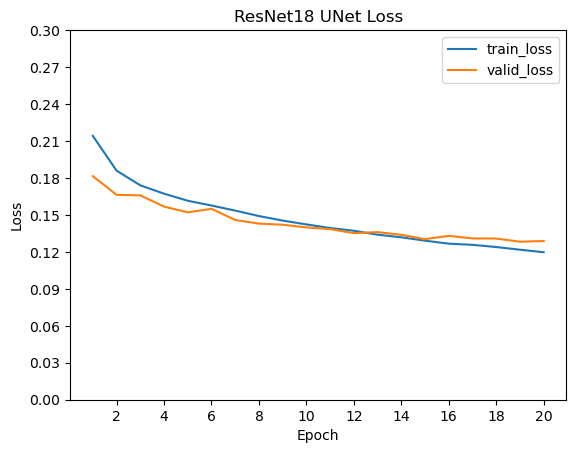

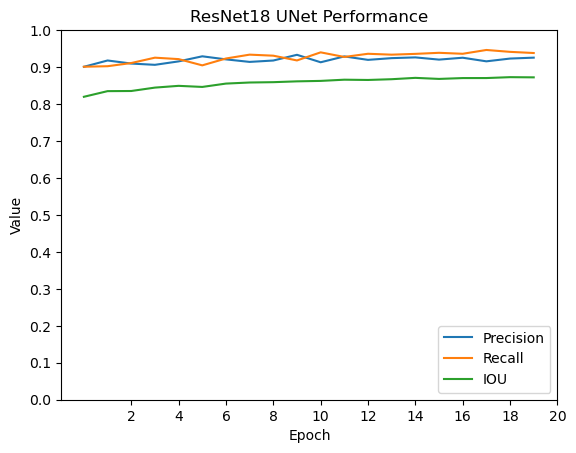

In [14]:
plot_losses("ResNet18 UNet Loss", training_loss, valid_loss)
plot_metrics("ResNet18 UNet Performance", metrics)

In [ ]:
fc18 = ResNet_FC(input_image_size=INPUT_IMAGE_SIZE).to(DEVICE)
fc18_train, fc18_metrics = train(fc18, dataset)
fc18_valid = [x['Loss'] for x in fc18_metrics]

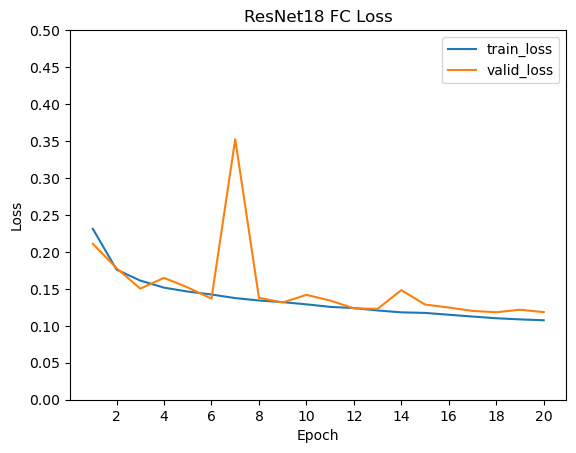

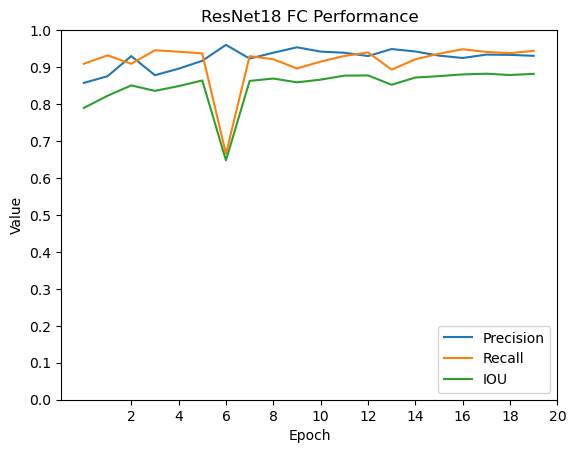

In [18]:
plot_losses("ResNet18 FC Loss", fc18_train, fc18_valid, y_max=0.5)
plot_metrics("ResNet18 FC Performance", fc18_metrics)

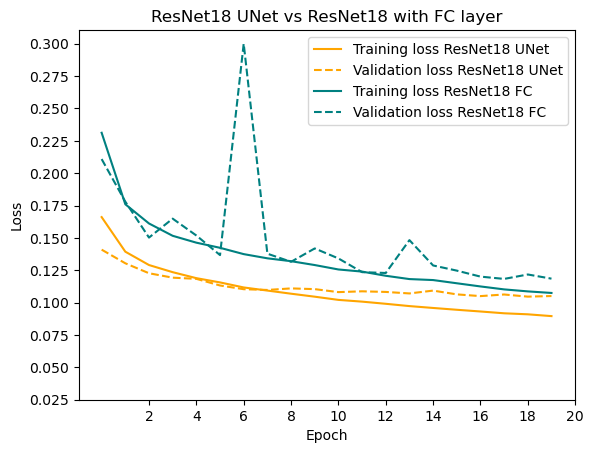

In [49]:
plot_loss_comparison("ResNet18 UNet vs ResNet18 with FC layer", resnet18_train, fc18_train, resnet18_valid, fc18_valid, compare1='ResNet18 UNet', compare2='ResNet18 FC')

We can see that the ResNet18 UNet converges with a higher performance than the ResNet18 with a fully connected layer, despite having less trainable parameters. The UNet converges around epoch 8, and we begin to see overfitting without performance gain after that.

# ResNet50 Backbone

In [ ]:
# U-Net model that uses a ResNet50 from SSL4EO-12. https://github.com/zhu-xlab/SSL4EO-S12
# The ResNet is pretrained on Sentinel-2 3-channel RGB satellite imagery

BATCH_SIZE = 128 # GPU wasn't big enough for 256
resnet50 = resnet50(weights=get_weight("ResNet50_Weights.SENTINEL2_RGB_SECO"))

resnet50 = ResNet_UNet(input_image_size=INPUT_IMAGE_SIZE).to(DEVICE)
resnet50_train, resnet50_metrics = train(resnet50, dataset)
resnet50_valid = [x['Loss'] for x in resnet50_metrics]

del resnet50
gc.collect()

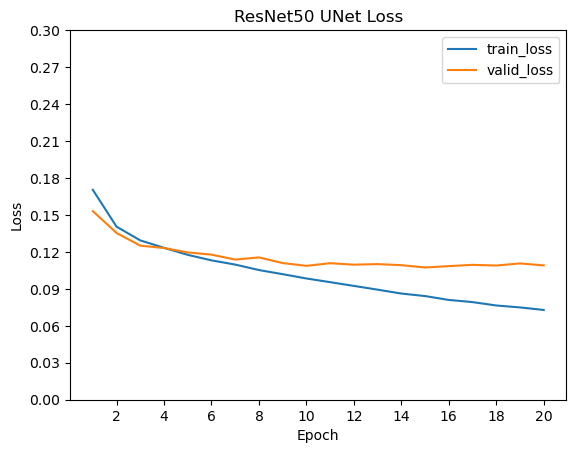

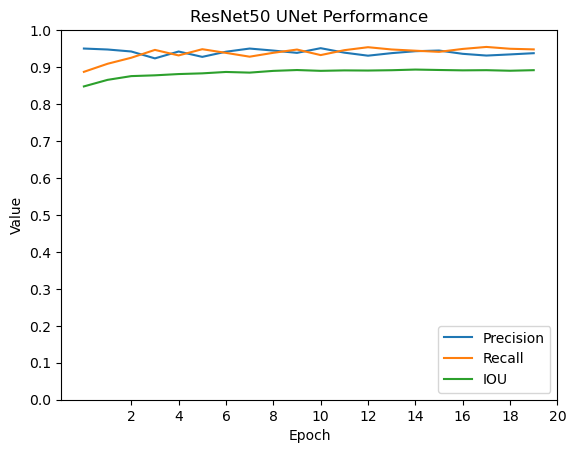

In [19]:
plot_losses("ResNet50 UNet Loss", resnet50_train, resnet50_valid)
plot_metrics("ResNet50 UNet Performance", resnet50_metrics)


In [ ]:
# ResNet50 with fully connected layer
# We are reducing the number of epochs to 10 due to overfitting seen in every model after epoch 10.
NUM_EPOCHS = 10
BATCH_SIZE = 128

fc50 = ResNet_FC(ResNet=resnet50(weights=ResNet50_Weights.DEFAULT), input_image_size=INPUT_IMAGE_SIZE).to(DEVICE)
fc50_train, fc50_metrics = train(fc50, dataset)
fc50_valid = [x['Loss'] for x in fc50_metrics]

del fc50
gc.collect()

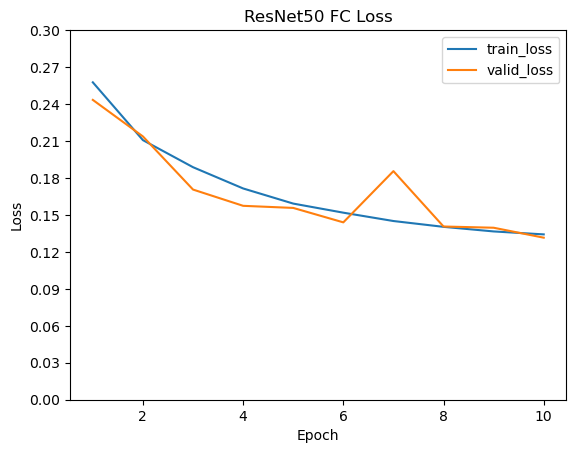

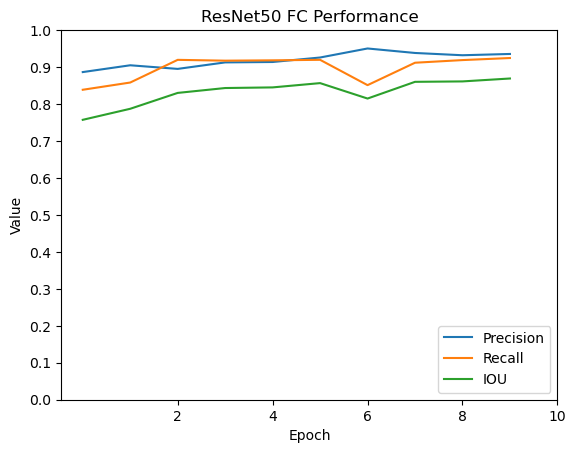

In [11]:
NUM_EPOCHS = 10
plot_losses("ResNet50 FC Loss", fc50_train, fc50_valid)
plot_metrics("ResNet50 FC Performance", fc50_metrics)

In [3]:
# Number of parameters
fc18 = ResNet_FC()
res18 = ResNet_UNet()
fc50 = ResNet_FC(ResNet=resnet50())
res50 = ResNet_UNet(ResNet=resnet50())

fc_params = sum(p.numel() for p in fc18.parameters())
res18_params = sum(p.numel() for p in res18.parameters())
fc50_params = sum(p.numel() for p in fc50.parameters())
res50_params = sum(p.numel() for p in res50.parameters())

print(f"ResNet18 with FC layer: {fc_params}\nResNet18 UNet: {res18_params}\nResNet50 with FC layer: {fc50_params}\nResNet50 UNet: {res50_params}")

ResNet18 with FC layer: 19581504
ResNet18 UNet: 15907914
ResNet50 with FC layer: 57078848
ResNet50 UNet: 99179594


# Results

[[0.9304, 0.9439, 0.8817], [0.939, 0.9505, 0.895], [0.9354, 0.9245, 0.8691], [0.9449, 0.9378, 0.8892]]


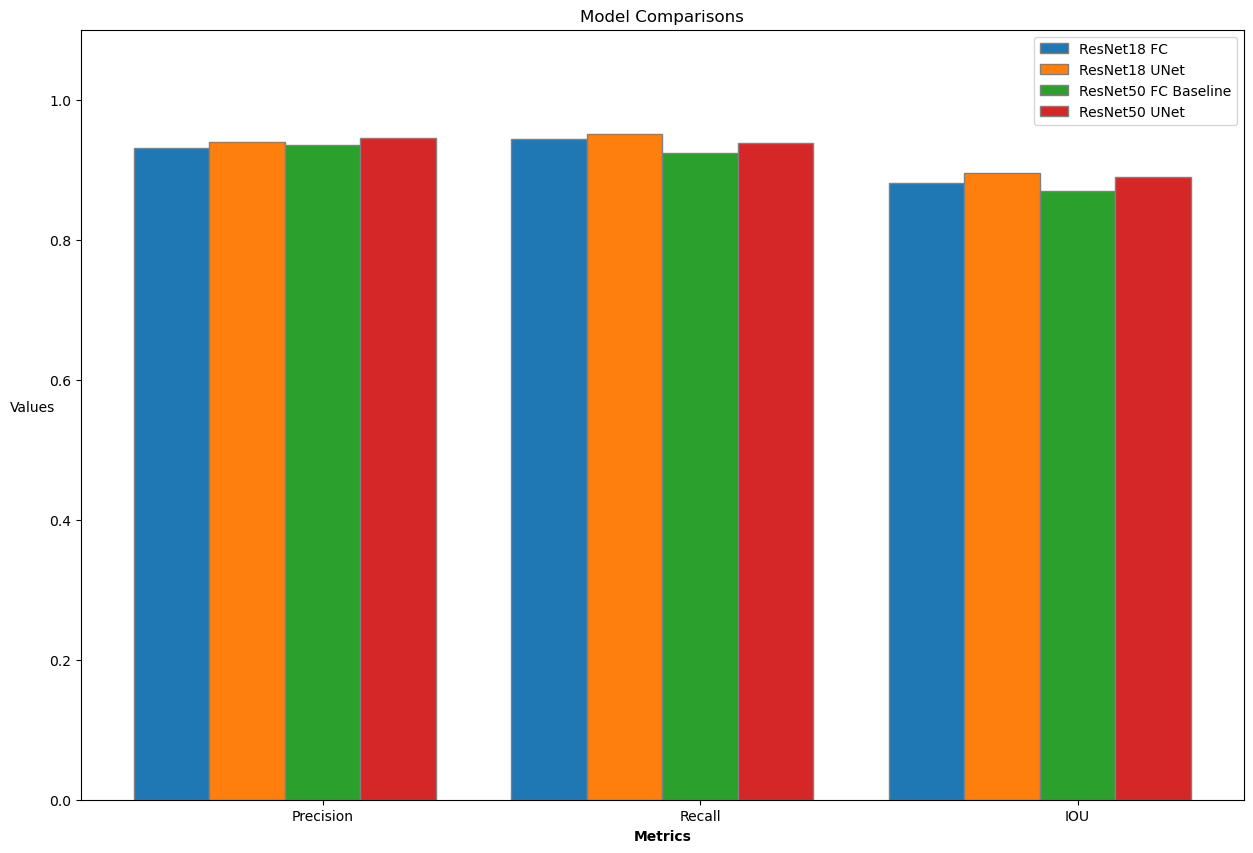

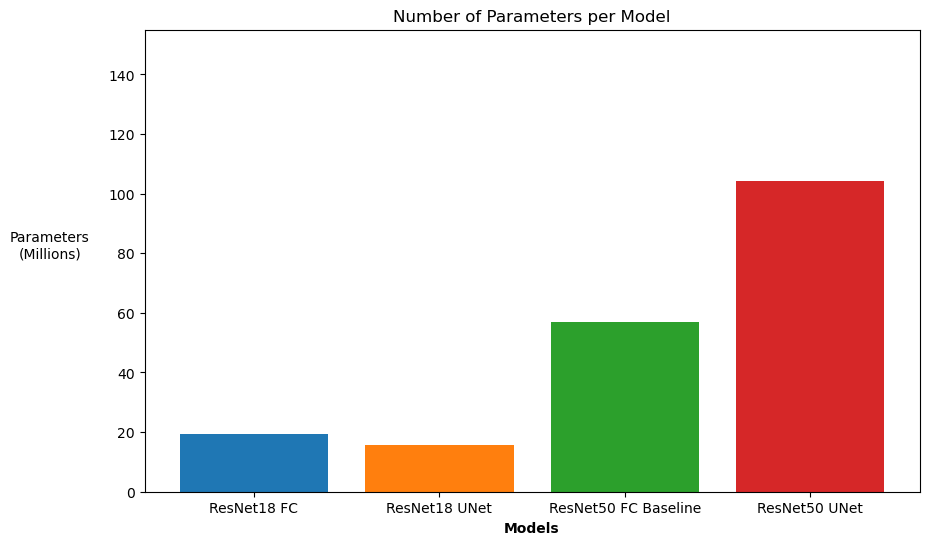

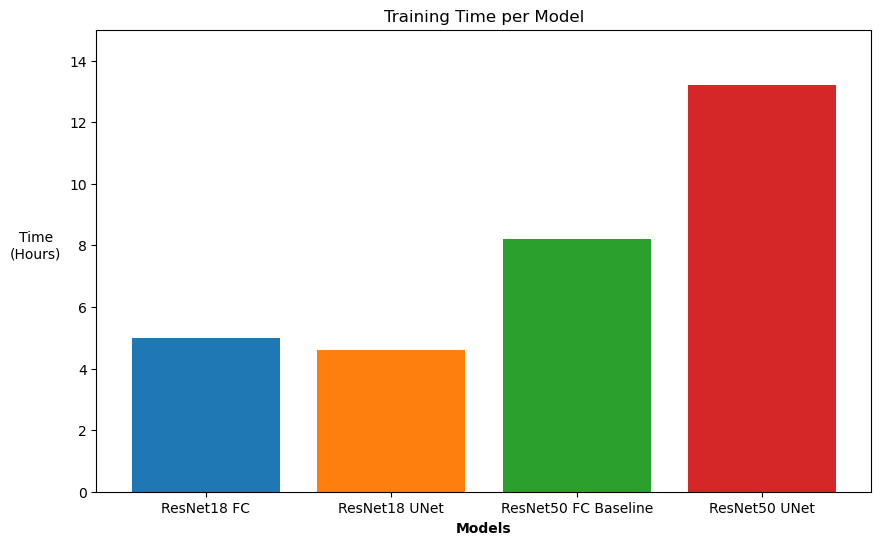

In [15]:
"""
ResNet18 UNet:
Epoch: 20/20
Train loss: 0.089591, Test loss: 0.1051

Validation Metrics:
Precision: 0.9390358130068557
Recall: 0.9505441267141128
f1_score: 0.9447549246947305
IOU: 0.8952943224316158
Accuracy: 0.9626174812789461
Specificity: 0.9687343658266366


ResNet18 FC:
Epoch: 20/20
Train loss: 0.107484, Test loss: 0.1185

Validation Metrics:
Precision: 0.9304596370170144
Recall: 0.943913300441753
f1_score: 0.9371381856326934
IOU: 0.8817121595346303
Accuracy: 0.9574169018041074
Specificity: 0.9642584113910695


ResNet50 UNet:
Epoch: 20/20
Train loss: 0.072857, Test loss: 0.1090

Validation Metrics:
Precision: 0.9375810742343926
Recall: 0.9478770521637422
f1_score: 0.9427009514208111
IOU: 0.8916124087008533
Accuracy: 0.9612521733214564
Specificity: 0.9680285892887657

ResNet50 FC:

Epoch: 10/10
Train loss: 0.134199, Test loss: 0.1315

Validation Metrics:
Precision: 0.9354888824944854
Recall: 0.9245074643618123
f1_score: 0.9299657562827044
IOU: 0.8690990608412738
Accuracy: 0.9531752160877339
Specificity: 0.9676995413798664
"""


resnet_fc18 = [{'Precision':0.9304, "Recall":0.9439, "IOU":0.8817}]
resnet_18 = [{'Precision':0.939, "Recall":0.9505, "IOU":0.895}]
resnet_fc50 = [{'Precision':0.9354, "Recall":0.9245, "IOU":0.8691}]
resnet_50 = [{'Precision':0.9449, "Recall":0.9378, "IOU":0.8892}]



metrics = []
metrics.append(resnet_fc18)
metrics.append(resnet_18)
metrics.append(resnet_fc50)
metrics.append(resnet_50)

# The FC model is the architecture from the 2020 mangrove monitoring paper, 
# so it is used as a baseline. It uses a resnet50 backbone and a fully connected layer for segmentation.
titles = ['ResNet18 FC', 'ResNet18 UNet', 'ResNet50 FC Baseline', 'ResNet50 UNet']

# Time to train for 20 epochs with RTX4090 using Memory mapped 120GB dataset
# Hours
training_time = []
training_time.append([{'time' : 5}]) #18 FC
training_time.append([{'time' : 4.6}]) #18 unet
training_time.append([{'time' : 8.2}]) #50 FC
training_time.append([{'time' : 13.2}]) #50 unet


# Number of parameters the network contains
parameters = []
parameters.append([{'Params' : 19.5}]) # 18 FC
parameters.append([{'Params' : 15.7}]) # 18 unet
parameters.append([{'Params' : 57.0}]) # 50 FC
parameters.append([{'Params' : 104.1}]) # 50 unet


# plot_loss_comparison("ResNet18 UNet vs ResNet50 UNet", resnet18_train, resnet50_train, resnet18_valid, resnet50_valid, compare1='ResNet18', compare2='ResNet50')
plot_comparison_metrics("Model Comparisons", metrics, titles, size=(15.0, 10.0))
plot_comparison_metrics("Number of Parameters per Model", parameters, titles, metrics_wanted=['Params'], x_label = 'Models', y_label='Parameters\n(Millions)', y_lim=155, single_metric=True)
plot_comparison_metrics("Training Time per Model", training_time, titles, metrics_wanted=['time'], x_label = 'Models', y_label='Time\n(Hours)', y_lim=15, single_metric=True)

We begin to see significant overfitting from the ResNet50 model after epoch 7. It also performs about the same as the ResNet18 UNet. The task that the model is performing is relatively simple, so quick convergence and overfitting is expected from a larger model with many trainable parameters. As such, single region mangrove classification is preferably done with a small model trained for few epochs. The number of epochs should scale inversely with the amount of training data. When testing with a 2GB dataset, we did not see convergence until about epoch 30.

Based on our results, the ideal model should be a ResNet18 UNet trained for 10 epochs on our 120GB dataset. It is possible that we could get similar performance from an even smaller model if a more efficient representation becomes necessary.

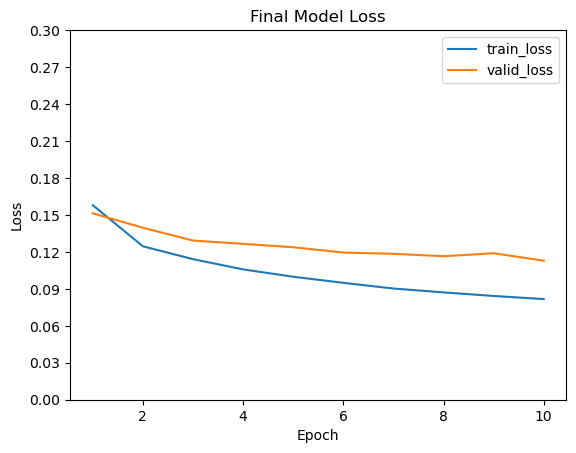

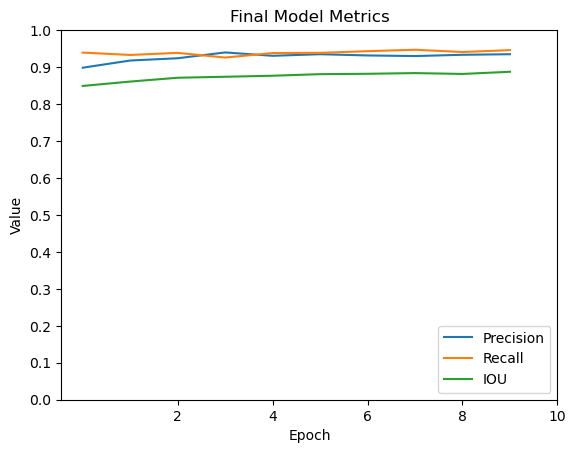

'\n\n'

In [13]:
plot_losses("Final Model Loss", training_loss, valid_loss)
plot_metrics("Final Model Metrics", metrics)

"""
Epoch 10/10:
 Batch 1570/1570
100%|██████████| 10/10 [2:27:09<00:00, 889.19s/it]
Epoch: 10/10
Train loss: 0.081702, Test loss: 0.1129

Validation Metrics:
Precision: 0.9347935675842424
Recall: 0.9458884673256911
f1_score: 0.9403082908169738
IOU: 0.8873413679360656
Accuracy: 0.9592193525674622
Specificity: 0.9660738932629552
"""